#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Meningkatkan Performa Jaringan Neural

**Tujuan Pembelajaran:** Meningkatkan performa jaringan neural dengan menormalisasikan fitur dan menerapkan berbagai algoritme pengoptimalan

**CATATAN:** Metode pengoptimalan yang dijelaskan dalam latihan ini tidak spesifik untuk jaringan neural; metode tersebut efektif untuk meningkatkan sebagian besar jenis model.

## Penyiapan

Pertama, kita akan memuat data.

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

TensorFlow 1.x selected.


In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2640.7,538.3,1425.5,499.7,3.9,2.0
std,2.1,2.0,12.6,2191.2,422.5,1161.7,384.4,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1452.0,295.0,786.0,280.0,2.6,1.5
50%,34.3,-118.5,29.0,2127.0,433.0,1168.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3141.2,645.0,1714.0,602.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2650.8,542.2,1439.4,504.9,3.9,2.0
std,2.1,2.0,12.6,2152.8,419.0,1113.9,384.8,1.9,1.2
min,32.5,-124.2,1.0,11.0,3.0,8.0,4.0,0.5,0.1
25%,33.9,-121.7,18.0,1479.0,301.0,796.8,284.0,2.6,1.5
50%,34.2,-118.5,29.0,2129.0,436.0,1166.0,412.0,3.6,1.9
75%,37.7,-118.0,37.0,3170.0,656.0,1740.0,610.0,4.8,2.3
max,42.0,-114.6,52.0,32054.0,5290.0,15507.0,5050.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.2
std,115.6
min,15.0
25%,119.1
50%,181.1
75%,265.3
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.4
std,116.9
min,17.5
25%,120.7
50%,178.3
75%,263.9
max,500.0


## Melatih Jaringan Neural

Berikutnya, kita akan melatih jaringan neural.

In [5]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 153.17
  period 01 : 134.23
  period 02 : 121.76
  period 03 : 114.14
  period 04 : 110.78
  period 05 : 110.48
  period 06 : 106.19
  period 07 : 105.39
  period 08 : 104.88
  period 09 : 102.33
Model training finished.
Final RMSE (on training data):   102.33
Final RMSE (on validation data): 101.98


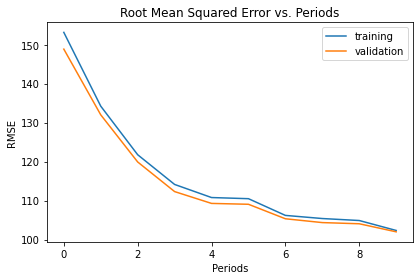

In [9]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Penskalaan Linear
Menormalisasikan masukan agar nilainya berada dalam kisaran -1, 1 bisa menjadi praktik standar yang baik. Tindakan ini membantu agar PGS tidak terjebak dengan mengambil langkah yang terlalu besar dalam satu dimensi, atau terlalu kecil dalam dimensi lain. Penggemar pengoptimalan numerik mungkin melihat adanya hubungan dengan ide penggunaan pra-kondisioner di sini.

In [10]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

## Tugas 1: Menormalisasikan Fitur Menggunakan Penskalaan Linear

**Normalisasikan masukan ke skala -1, 1.**

**Luangkan waktu sekitar 5 menit untuk melatih dan mengevaluasi data yang baru saja dinormalisasi. Seberapa baik Anda melakukannya?**

Sebagai aturan praktis, JN dilatih dengan paling baik saat fitur masukan kira-kira berada pada skala yang sama.

Periksa data Anda yang dinormalisasi. (Apa yang akan terjadi jika Anda lupa untuk menormalisasikan satu fitur?)


Training model...
RMSE (on training data):
  period 00 : 231.44
  period 01 : 209.11
  period 02 : 162.92
  period 03 : 117.02
  period 04 : 112.78
  period 05 : 108.70
  period 06 : 103.80
  period 07 : 98.04
  period 08 : 91.55
  period 09 : 85.45
Model training finished.
Final RMSE (on training data):   85.45
Final RMSE (on validation data): 86.38


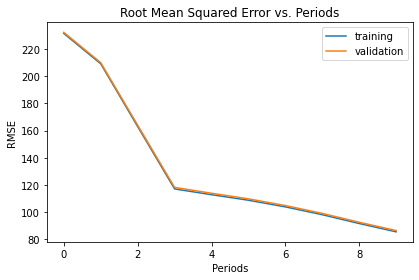

In [11]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  #
  # Your code here: normalize the inputs.
  #
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features


normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah untuk mendapatkan satu solusi yang memungkinkan.

Karena normalisasi menggunakan nilai min dan maks, kita harus memastikan tindakan tersebut dilakukan di seluruh kumpulan data sekaligus.

Kita dapat melakukannya di sini karena semua data berada dalam satu DataFrame. Jika kita memiliki beberapa kumpulan data, sebaiknya dapatkan parameter normalisasi dari set pelatihan dan terapkan secara identik ke set pengujian.

In [12]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):


KeyboardInterrupt: ignored

## Tugas 2: Mencoba Pengoptimal yang Berbeda

** Gunakan pengoptimal Adagrad dan Adam, lalu bandingkan performanya.**

Pengoptimal Adagrad adalah salah satu alternatifnya. Analisis utama dari Adagrad adalah memodifikasi kecepatan pembelajaran secara adaptif untuk setiap koefisien dalam model, yang secara monoton menurunkan kecepatan pembelajaran yang efektif. Cara ini berfungsi dengan baik untuk masalah konveks, namun tidak selalu sesuai untuk pelatihan Jaringan Neural masalah non-konveks. Anda dapat menggunakan pengoptimal Adagrad dengan menentukan `AdagradOptimizer`, bukannya `GradientDescentOptimizer`. Perlu diperhatikan bahwa Anda mungkin perlu menggunakan kecepatan pembelajaran yang lebih besar dengan pengoptimal Adagrad.

Untuk masalah pengoptimalan non-konveks, terkadang pengoptimal Adam lebih efisien dibandingkan Adagrad. Untuk menggunakan pengoptimal Adam, terapkan metode `tf.train.AdamOptimizer`. Metode ini membutuhkan beberapa hyperparameter opsional sebagai argumen, tetapi dalam solusi kita hanya satu di antaranya yang ditentukan (`learning_rate`). Dalam setelan produksi, Anda harus menentukan dan menyelaraskan hyperparameter opsional dengan cermat.

Training model...
RMSE (on training data):
  period 00 : 235.57
  period 01 : 233.97
  period 02 : 231.42
  period 03 : 228.97
  period 04 : 226.51
  period 05 : 223.95
  period 06 : 221.21
  period 07 : 218.33
  period 08 : 215.35
  period 09 : 212.29
Model training finished.
Final RMSE (on training data):   212.29
Final RMSE (on validation data): 213.11


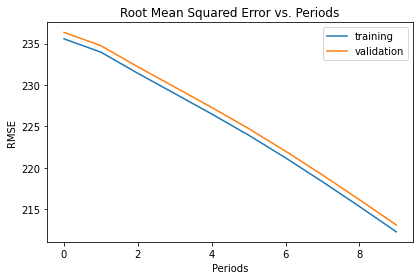

In [13]:
#
# YOUR CODE HERE: Retrain the network using Adagrad and then Adam.
#
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])
  processed_features["total_rooms"] = linear_scale(examples_dataframe["total_rooms"])
  processed_features["total_bedrooms"] = linear_scale(examples_dataframe["total_bedrooms"])
  processed_features["population"] = linear_scale(examples_dataframe["population"])
  processed_features["households"] = linear_scale(examples_dataframe["households"])
  processed_features["median_income"] = linear_scale(examples_dataframe["median_income"])
  processed_features["rooms_per_person"] = linear_scale(examples_dataframe["rooms_per_person"])
  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.005),
    steps=2000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah untuk mendapatkan solusinya

Pertama, mari coba pengoptimal Adagrad.

Training model...
RMSE (on training data):
  period 00 : 81.20
  period 01 : 73.97
  period 02 : 72.10
  period 03 : 71.02
  period 04 : 70.55
  period 05 : 70.40
  period 06 : 69.41
  period 07 : 71.21
  period 08 : 68.42
  period 09 : 68.84
Model training finished.
Final RMSE (on training data):   68.84
Final RMSE (on validation data): 70.89


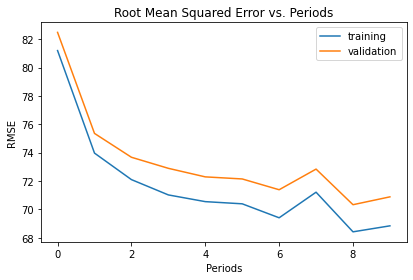

In [14]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Sekarang mari coba pengoptimal Adam.

Training model...
RMSE (on training data):
  period 00 : 214.99
  period 01 : 127.64
  period 02 : 115.91
  period 03 : 109.07
  period 04 : 95.49
  period 05 : 78.80
  period 06 : 71.51
  period 07 : 71.20
  period 08 : 70.23
  period 09 : 69.51
Model training finished.
Final RMSE (on training data):   69.51
Final RMSE (on validation data): 71.21


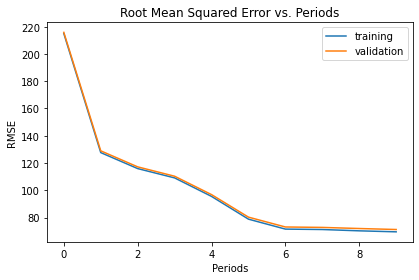

In [15]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.009),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Mari cetak grafik metrik kerugian secara berdampingan.

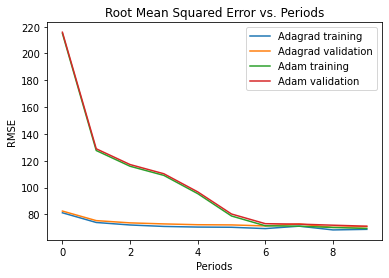

In [16]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

## Tugas 3: Menjelajahi Metode Normalisasi Alternatif

**Cobalah normalisasi alternatif untuk berbagai fitur guna meningkatkan performanya lebih lanjut.**

Jika statistik ringkasan untuk data yang diubah diperhatikan lebih cermat, Anda mungkin menyadari bahwa melakukan penskalaan linear terhadap beberapa fitur membuatnya berkelompok mendekati `-1`.

Misalnya, banyak fitur memiliki median sekitar`-0,8`, bukannya `0,0`.

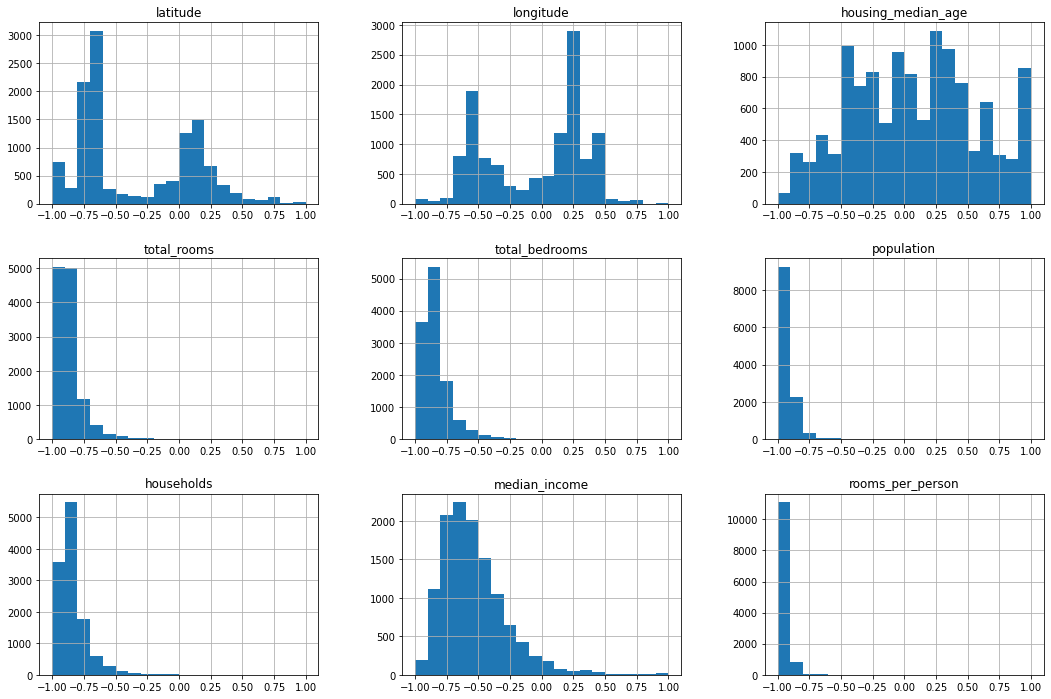

In [17]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

Kita mungkin dapat melakukannya lebih baik dengan memilih cara tambahan untuk mengubah fitur ini.

Misalnya, penskalaan log mungkin membantu beberapa fitur. Atau pemotongan nilai yang ekstrem dapat membuat sisa skalanya lebih informatif.

In [18]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

Blok di atas berisi beberapa fungsi normalisasi tambahan yang memungkinkan. Cobalah beberapa fungsi tersebut, atau tambahkan milik Anda sendiri.

Perlu diketahui bahwa jika menormalisasikan target, Anda harus membatalkan normalisasi terhadap prediksi untuk metrik kerugian agar nilainya sebanding.

Training model...
RMSE (on training data):
  period 00 : 199.28
  period 01 : 118.20
  period 02 : 113.00
  period 03 : 110.92
  period 04 : 108.50
  period 05 : 105.23
  period 06 : 100.88
  period 07 : 95.76
  period 08 : 90.45
  period 09 : 86.04
Model training finished.
Final RMSE (on training data):   86.04
Final RMSE (on validation data): 86.47


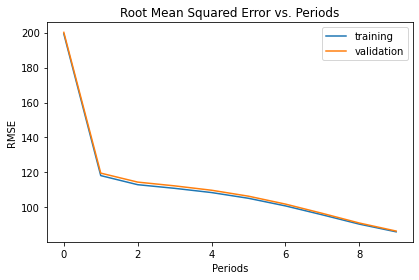

In [19]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""

  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0007),
    steps=5000,
    batch_size=70,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Solusi

Klik di bawah untuk mendapatkan satu solusi yang memungkinkan.

Ini hanyalah beberapa cara di mana kita bisa memikirkan data. Transformasi lainnya bahkan mungkin berfungsi lebih baik!

`households`, `median_income`, dan `total_bedrooms` semuanya tampak terdistribusi secara normal di ruang log.

Seperti sebelumnya, `latitude`, `longitude`, dan `housing_median_age` mungkin akan lebih baik jika hanya diskalakan secara linear.

`population`, `totalRooms`, dan `rooms_per_person` memiliki beberapa pencilan yang ekstrem. Pencilan tersebut tampak terlalu ekstrem untuk penerapan normalisasi log. Jadi, mari kita potong saja.

In [ ]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["households"] = log_normalize(examples_dataframe["households"])
  processed_features["median_income"] = log_normalize(examples_dataframe["median_income"])
  processed_features["total_bedrooms"] = log_normalize(examples_dataframe["total_bedrooms"])
  
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  processed_features["housing_median_age"] = linear_scale(examples_dataframe["housing_median_age"])

  processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
  processed_features["rooms_per_person"] = linear_scale(clip(examples_dataframe["rooms_per_person"], 0, 5))
  processed_features["total_rooms"] = linear_scale(clip(examples_dataframe["total_rooms"], 0, 10000))

  return processed_features

normalized_dataframe = normalize(preprocess_features(california_housing_dataframe))
normalized_training_examples = normalized_dataframe.head(12000)
normalized_validation_examples = normalized_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.15),
    steps=1000,
    batch_size=50,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## Tantangan Opsional: Hanya gunakan Fitur Garis Lintang dan Garis Bujur

**Latih model JN yang hanya menggunakan garis lintang dan bujur sebagai fitur.**

Orang real estate sering menyatakan bahwa lokasi adalah satu-satunya fitur yang penting dalam harga perumahan.
Mari lihat apakah kita dapat membuktikan pernyataan ini dengan melatih model yang hanya menggunakan garis lintang dan bujur sebagai fitur.

Cara ini hanya akan berfungsi dengan baik jika JN kita dapat mempelajari nonlinearitas kompleks dari garis lintang dan bujur.

**CATATAN:** Kita mungkin membutuhkan struktur jaringan yang memiliki lebih banyak lapisan daripada lapisan yang sebelumnya berguna dalam latihan.

In [ ]:
#
# YOUR CODE HERE: Train the network using only latitude and longitude
#

### Solusi

Klik di bawah untuk mendapatkan solusi yang memungkinkan.

Mempertahankan normalisasi garis lintang dan bujur adalah ide yang bagus:

Training model...
RMSE (on training data):
  period 00 : 109.48
  period 01 : 105.73
  period 02 : 102.94
  period 03 : 101.73
  period 04 : 100.61
  period 05 : 99.12
  period 06 : 98.76
  period 07 : 98.54
  period 08 : 98.49
  period 09 : 97.97
Model training finished.
Final RMSE (on training data):   97.97
Final RMSE (on validation data): 100.26


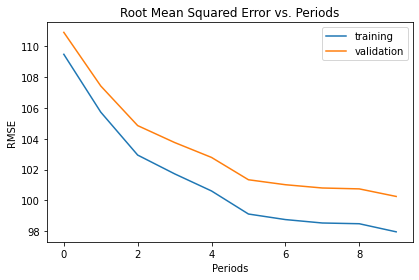

In [20]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the latitude and longitude."""
  processed_features = pd.DataFrame()
  processed_features["latitude"] = linear_scale(examples_dataframe["latitude"])
  processed_features["longitude"] = linear_scale(examples_dataframe["longitude"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(california_housing_dataframe))
lll_training_examples = lll_dataframe.head(12000)
lll_validation_examples = lll_dataframe.tail(5000)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.05),
    steps=500,
    batch_size=50,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)

Cara ini tidak terlalu buruk untuk hanya dua fitur. Tentu saja, nilai properti masih dapat sangat berbeda dalam jarak dekat.